In [ ]:
!pip install torch

In [ ]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=column_names, skipinitialspace=True)
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [12]:
# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Handle missing values
data.dropna(inplace=True)

# Separate features and target
X = data.drop('income', axis=1)
y = (data['income'] == '>50K').astype(int)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing
numerical_features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss', 'fnlwgt']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_val_num = scaler.transform(X_val[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_val_cat = encoder.transform(X_val[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# Combine preprocessed features
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_val_processed = np.hstack([X_val_num, X_val_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [15]:
# Define MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
def report_nn_structure(model):
    structure = []
    for i, layer in enumerate(model.model):
        if isinstance(layer, nn.Linear):
            structure.append({
                'Layer': f'Hidden {i//2 + 1}' if i < len(model.model) - 2 else 'Output',
                'Type': 'Linear',
                'Input Neurons': layer.in_features,
                'Output Neurons': layer.out_features,
                'Activation': 'ReLU' if i < len(model.model) - 2 else 'Sigmoid'
            })

    df = pd.DataFrame(structure)
    print("\nNeural Network Structure:")
    print(df.to_string(index=False))
    print(f"\nTotal number of hidden layers: {len(structure) - 1}")

In [16]:
# Model parameters
input_size = X_train_processed.shape[1]
model = MLPModel(input_size)

# Report neural network structure
report_nn_structure(model)


Neural Network Structure:
   Layer   Type  Input Neurons  Output Neurons Activation
Hidden 1 Linear            108             128       ReLU
Hidden 2 Linear            128              64       ReLU
Hidden 3 Linear             64              32       ReLU
  Output Linear             32               1    Sigmoid

Total number of hidden layers: 3


In [35]:
# Loss, optimizer, and scheduler
criterion = nn.BCELoss()
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_params = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_preds = (outputs > 0.5).float()
        train_accuracy = (train_preds == y_train).float().mean()

        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy.item())
        torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_preds = (val_outputs > 0.5).float()
            val_accuracy = (val_preds == y_val).float().mean().item()

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save model parameters for this epoch
        epoch_params.append(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, epoch_params

Epoch 1/150, Train Loss: 0.7141, Train Acc: 0.2385, Val Loss: 0.7102, Val Acc: 0.2351
Epoch 2/150, Train Loss: 0.7101, Train Acc: 0.2380, Val Loss: 0.7064, Val Acc: 0.2355
Epoch 3/150, Train Loss: 0.7063, Train Acc: 0.2382, Val Loss: 0.7026, Val Acc: 0.2379
Epoch 4/150, Train Loss: 0.7026, Train Acc: 0.2395, Val Loss: 0.6987, Val Acc: 0.2557
Epoch 5/150, Train Loss: 0.6987, Train Acc: 0.2578, Val Loss: 0.6945, Val Acc: 0.3860
Epoch 6/150, Train Loss: 0.6945, Train Acc: 0.3783, Val Loss: 0.6899, Val Acc: 0.6966
Epoch 7/150, Train Loss: 0.6899, Train Acc: 0.6927, Val Loss: 0.6849, Val Acc: 0.7609
Epoch 8/150, Train Loss: 0.6849, Train Acc: 0.7590, Val Loss: 0.6794, Val Acc: 0.7576
Epoch 9/150, Train Loss: 0.6794, Train Acc: 0.7575, Val Loss: 0.6735, Val Acc: 0.7576
Epoch 10/150, Train Loss: 0.6735, Train Acc: 0.7575, Val Loss: 0.6673, Val Acc: 0.7576
Epoch 11/150, Train Loss: 0.6673, Train Acc: 0.7575, Val Loss: 0.6606, Val Acc: 0.7576
Epoch 12/150, Train Loss: 0.6606, Train Acc: 0.7575,

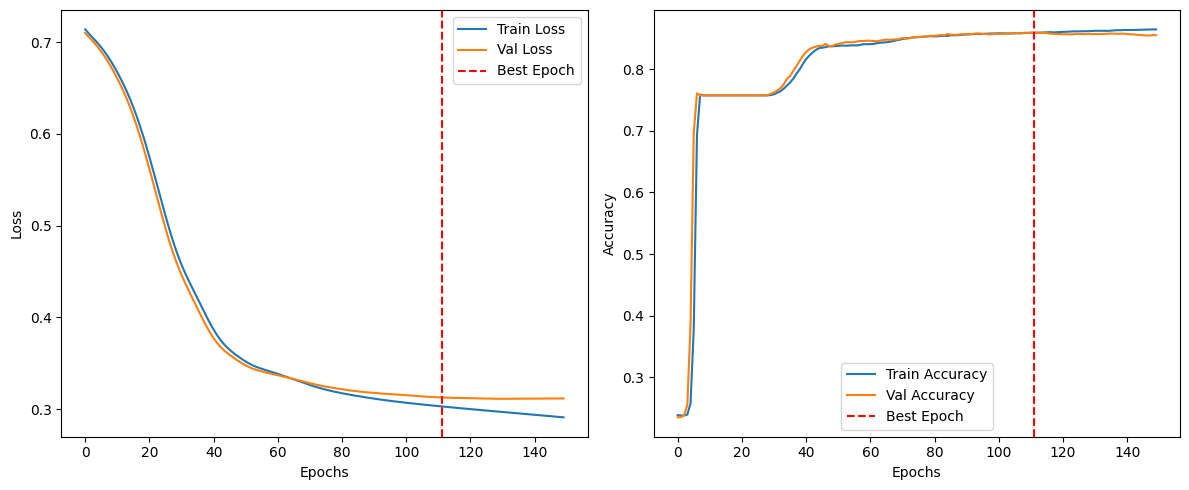

In [36]:
# Model parameters
input_size = X_train_processed.shape[1]
model = MLPModel(input_size)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, epoch_params = train_model(
    model, criterion, optimizer,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    epochs=150
)

# Find the best epoch based on validation accuracy
best_epoch = val_accuracies.index(max(val_accuracies))

# Load the best model parameters
model.load_state_dict(epoch_params[best_epoch])

# Report best epoch and its performance
print(f"\nBest model performance was at epoch {best_epoch + 1}")
print(f"Best validation accuracy: {val_accuracies[best_epoch]:.4f}")
print(f"Corresponding training accuracy: {train_accuracies[best_epoch]:.4f}")
print(f"Corresponding validation loss: {val_losses[best_epoch]:.4f}")
print(f"Corresponding training loss: {train_losses[best_epoch]:.4f}")

# Plot losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
def report_model_structure(model):
    print("\nNeural Network Structure:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.shape}")
            total_params += param.numel()
    print(f"\nTotal trainable parameters: {total_params}")

# After finding the best epoch and loading its parameters:
best_epoch = val_accuracies.index(max(val_accuracies))
model.load_state_dict(epoch_params[best_epoch])

print(f"\nBest model performance was at epoch {best_epoch + 1}")
print(f"Best validation accuracy: {val_accuracies[best_epoch]:.4f}")
print(f"Corresponding training accuracy: {train_accuracies[best_epoch]:.4f}")
print(f"Corresponding validation loss: {val_losses[best_epoch]:.4f}")
print(f"Corresponding training loss: {train_losses[best_epoch]:.4f}")

# Report the structure of the best model
report_model_structure(model)



Best model performance was at epoch 112
Best validation accuracy: 0.8595
Corresponding training accuracy: 0.8592
Corresponding validation loss: 0.3126
Corresponding training loss: 0.3029

Neural Network Structure:
model.0.weight: torch.Size([128, 108])
model.0.bias: torch.Size([128])
model.2.weight: torch.Size([64, 128])
model.2.bias: torch.Size([64])
model.4.weight: torch.Size([32, 64])
model.4.bias: torch.Size([32])
model.6.weight: torch.Size([1, 32])
model.6.bias: torch.Size([1])

Total trainable parameters: 24321


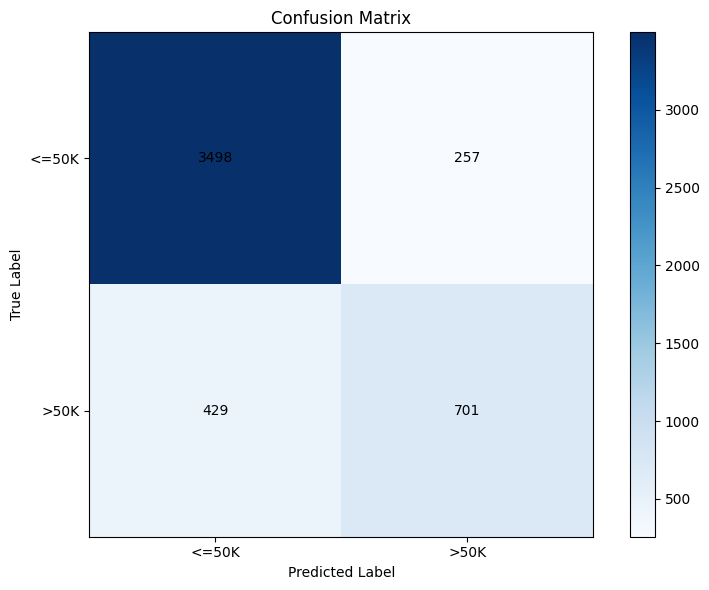

              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      3755
        >50K       0.73      0.62      0.67      1130

    accuracy                           0.86      4885
   macro avg       0.81      0.78      0.79      4885
weighted avg       0.85      0.86      0.86      4885



In [41]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()
    cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['<=50K', '>50K'])
    plt.yticks(tick_marks, ['<=50K', '>50K'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    print(classification_report(y_test_tensor.numpy(), test_preds.numpy(), target_names=['<=50K', '>50K']))